In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

from models import deconvolution

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = 'cpu'

torch.set_default_device(device)

In [9]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = int(2*N)
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

n_datasize = 1000
dataset = np.zeros((n_datasize, n))
x = np.linspace(domain[0],domain[1], n)

for ii in range(0, n_datasize):
    n_params = np.random.randint(4, 10)
    idxs = np.sort(np.random.randint(0+5, n-5, n_params))
    params = np.sort(np.random.uniform(0, 2, n_params))
    params[::2] = 0
    true = np.zeros(x.shape)

    for jj in range(0, len(idxs[1:])):
        true[idxs[jj-1]:idxs[jj]] = params[jj]
    
    dataset[ii, :] = true


In [10]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

In [11]:
y_data = np.zeros((n_datasize, N))

for ii in range(0, n_datasize):
    f = dataset[ii, :]
    f = A@f
    ind = f > 0
    f *= ind

    # Create y_data with noise
    y_data[ii, :] = f + np.random.normal(0, sigma_noise, f.shape)

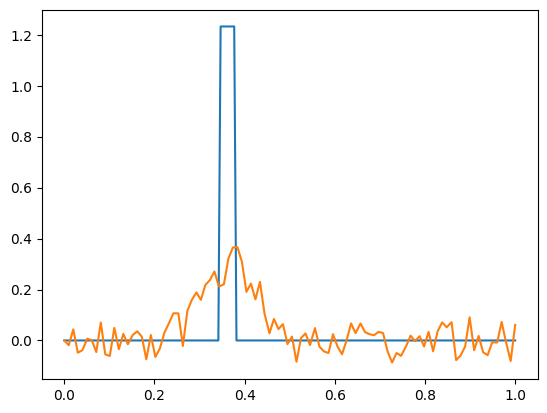

In [12]:
plt.plot(x, dataset[0, :])
plt.plot(t, y_data[0, :])

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Define the SignalNet class (as before)
class SignalNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(SignalNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Parameters
input_size = N 
output_size = n
hidden_size = 128
batch_size = 16
learning_rate = 0.001
num_epochs = 10000

# Generate dummy data
num_samples = n_datasize
X = torch.from_numpy(y_data).float()
y = torch.from_numpy(dataset).float()

# Create DataLoader
dataset_tensor = TensorDataset(X, y)
dataloader = DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = SignalNet(input_size, output_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/200], Loss: 0.1309
Epoch [2/200], Loss: 0.1136
Epoch [3/200], Loss: 0.0747
Epoch [4/200], Loss: 0.0849
Epoch [5/200], Loss: 0.0703
Epoch [6/200], Loss: 0.0717
Epoch [7/200], Loss: 0.0793
Epoch [8/200], Loss: 0.0570
Epoch [9/200], Loss: 0.0518
Epoch [10/200], Loss: 0.0570
Epoch [11/200], Loss: 0.0409
Epoch [12/200], Loss: 0.0757
Epoch [13/200], Loss: 0.0379
Epoch [14/200], Loss: 0.0875
Epoch [15/200], Loss: 0.0663
Epoch [16/200], Loss: 0.0521
Epoch [17/200], Loss: 0.0400
Epoch [18/200], Loss: 0.0594
Epoch [19/200], Loss: 0.0512
Epoch [20/200], Loss: 0.0633
Epoch [21/200], Loss: 0.0685
Epoch [22/200], Loss: 0.0547
Epoch [23/200], Loss: 0.0480
Epoch [24/200], Loss: 0.0513
Epoch [25/200], Loss: 0.0336
Epoch [26/200], Loss: 0.0850
Epoch [27/200], Loss: 0.0562
Epoch [28/200], Loss: 0.0337
Epoch [29/200], Loss: 0.0996
Epoch [30/200], Loss: 0.0375
Epoch [31/200], Loss: 0.0552
Epoch [32/200], Loss: 0.0544
Epoch [33/200], Loss: 0.0449
Epoch [34/200], Loss: 0.0603
Epoch [35/200], Loss: 0

In [15]:
model.eval()  # Set the model to evaluation mode

# Example input signal for prediction
input_signal = X[0,:]
# Make prediction
with torch.no_grad():  # No need to track gradients during inference
    output_signal = model(input_signal)

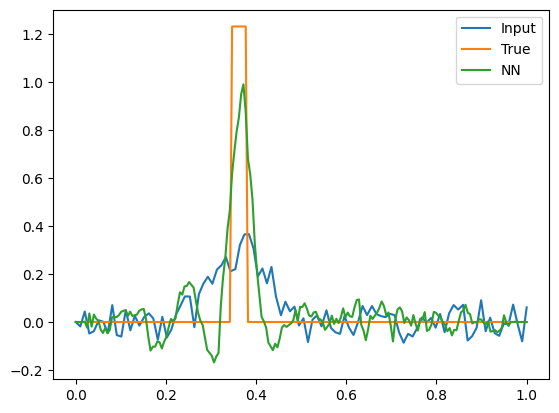

In [18]:
plt.plot(t, X[0,:])
plt.plot(x, y[0, :])
plt.plot(x, output_signal)

plt.legend(['Input', 'True', 'NN'])